### Import Libraries

In [ ]:
import os
import numpy as np
from skimage import io, color, transform
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Set Up Pre-Processing Functions for SVM & Train Model

In [ ]:
def preprocess_image(img_name, image_path, annotation_path, classes):
    """
    Purpose: Reads in the annotation file for the image and extracts the class ID. COnverts the image to RGB if it is RGBA. Resizes
    the image if necessary. Extracts Histogram of Gradients (HOG) features from the image and returns the HOG features and class ID.

    Returns: Tuple of HOG features and class ID

    Parameters:
    img_name (str): The name of the image file
    image_path (str): The path to the image files
    annotation_path (str): The path to the annotation files
    classes (list): The list of class names
    """

    # Here we are extracting the base name of the image file
    base_name = os.path.splitext(img_name)[0]
    # Here we are creating the path to the annotation file
    annotation_file = os.path.join(annotation_path, base_name + '.txt')

    if not os.path.exists(annotation_file):
        return None
    
    # Here we open the annotation file and attempt to extract the class ID
    with open(annotation_file, 'r') as file:
        annotation_line = file.readline()
        # The class ID is the first element in the annotation line of a YOLO annotation file
        class_id = int(annotation_line.split()[0])
        if class_id >= len(classes):
            return None
        
    # Here we read in the image file
    img_path = os.path.join(image_path, img_name)
    img = io.imread(img_path)

    # If the image is RGBA, we convert it to RGB
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img)

    # Here we resize the image to 128x64
    img_resized = transform.resize(img, (128, 64))

    # Here we extract the HOG features from the image
    if img_resized.ndim == 2:
        # We can use the hog function directly 
        hog_features = hog(img_resized, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
    else:
        hog_features = hog(img_resized, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False, channel_axis=-1)

    # Return the HOG features and class ID
    return hog_features, class_id


def load_image_label_pairs(image_path, annotation_path, classes):
    """
    Purpose: The function iterates over all the images in the image_path directory and extracts the HOG features and class ID 
    for each image via the preprocess_image function. The HOG features and class ID are stored in a list and returned.
    The threadpool executor is used to parallelize the processing of the images. Then the HOG features and IDs are aggregated into arrays. 

    Return: Tuple of HOG features and class IDs

    Parameters:
    image_path (str): The path to the image files
    annotation_path (str): The path to the annotation files
    classes (list): The list of class names
    """

    # Here we create empty lists of HOG features and class IDs
    data = []
    labels = []

    img_names = os.listdir(image_path)
    total = len(img_names)

    # Using the ThreadPoolExecutor to parallelize the processing of the images
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Create a progress bar because the process was taking a long time
        progress = tqdm(total=total, desc="Processing images", unit="img")
        # Here we submit the preprocess_image function to the executor
        futures = {executor.submit(preprocess_image, img_name, image_path, annotation_path, classes): img_name for img_name in img_names}

        # Here we iterate through the futures as they are completed
        for future in concurrent.futures.as_completed(futures):
            # Here we extract the result of the future
            result = future.result()
            # If the result is not None, we append the HOG features and class ID to the data and labels lists
            if result is not None:
                hog_features, class_id = result
                data.append(hog_features)
                labels.append(class_id)
            progress.update(1)
        progress.close()
    
    # Finally, we convert the data and labels lists to arrays and return them
    return np.array(data), np.array(labels)

# Here we define the classes for training 
classes = [
    'antelope', 'bat', 'bear', 'butterfly', 'Domestic short-haired cats',
    'chimpanzee', 'coyote', 'dolphin', 'eagle',
    'elephant', 'gorilla', 'hippopotamus', 'rhinoceros',
    'hummingbird', 'kangaroo', 'koala', 'leopard', 'lion',
    'lizard', 'orangutan', 'panda', 'penguin', 'seal',
    'shark', 'tiger', 'turtle', 'whale', 'zebra', 'bee'
]

# Paths to both image and annotation folders
image_path = '/content/drive/MyDrive/DL_Individual_Project_Engandered_Species/YOLO_Data/images/train'
annotation_path = '/content/drive/MyDrive/DL_Individual_Project_Engandered_Species/YOLO_Data/labels/train'

# Here we load the image and label pairs using the function we created. It also includes the first function. 
X, y = load_image_label_pairs(image_path, annotation_path, classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred = svm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=classes))

Processing images: 100%|██████████| 641/641 [16:47<00:00,  1.57s/img]


Accuracy: 0.13178294573643412
              precision    recall  f1-score   support

    antelope       0.25      0.20      0.22         5
         bat       0.00      0.00      0.00         2
        bear       0.00      0.00      0.00         6
   butterfly       0.00      0.00      0.00         5
         cat       0.00      0.00      0.00         4
  chimpanzee       0.14      0.25      0.18         4
      coyote       0.25      0.17      0.20         6
     dolphin       0.00      0.00      0.00         5
       eagle       0.00      0.00      0.00         3
    elephant       0.29      0.33      0.31         6
     gorilla       0.00      0.00      0.00         3
hippopotamus       0.00      0.00      0.00         3
  rhinoceros       0.50      0.17      0.25         6
 hummingbird       0.00      0.00      0.00         7
    kangaroo       0.25      0.17      0.20         6
       koala       0.00      0.00      0.00         2
     leopard       0.00      0.00      0.00        

### Visualize Output of SVM Model

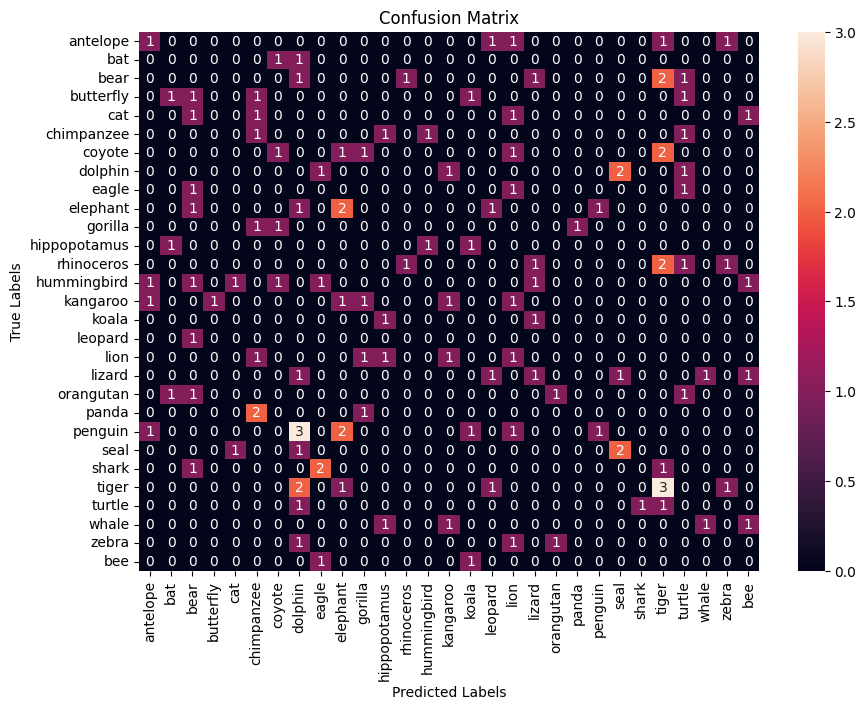

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
